In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

logger = logging.getLogger(__name__)

### SETUP

In [2]:
# Load precomputed data

MODE = '6and3'
with open(f'lattice/data_{MODE}.json', 'r') as f:
    data_dict = json.load(f)
groups = data_dict['groups']
groups_direct = data_dict['groups_direct']
all_groups = {**groups, **groups_direct}
indices = data_dict['indices']
null_knobs = data_dict['null_knobs']
dfknobs = pd.read_json(f'lattice/dfknobs_{MODE}.json')

# impact of K2L difference
dfknobs.loc['SM2B',:] *= 0.25/0.2

# DO NOT CHANGE - USED TO CALCULATE ABSOLUTE K2L
initial_values_ref = {
    'SM1A': -23.68063424*0.2,
    'SM2B': 28.64315469*0.25,
    'SM1B': -25.94603546*0.2,
    'SL3': -29.46086061*0.2,
    'SL2': 35.67792145*0.2,
    'SL1': -13.27160605*0.2,
    'SH4': -15.82090071*0.2,
    'SH3': -5.85510841*0.2,
    'SH1': 19.8329121*0.2,
}

# CHANGE THIS TO VALUES FROM RING IF NEEDED
initial_values = initial_values_ref.copy()

initial_values['SM1A'] *= 1.01
initial_values['SM1B'] *= 1.008

# optimizer variables in units of K2L
variables = {'SVD0':[-0.6,0.6]} # this means SM1B will change by ~10%
# variables = {'SVD0':[-0.4,0.4]} # this means SM1B will change by ~10%

for k in ['SH1','SH3','SH4','SL1','SL2','SL3']:
    variables[k] = [-np.abs(initial_values_ref[k])*0.1,np.abs(initial_values_ref[k])*0.1]
    # variables[k] = [-np.abs(initial_values_ref[k])*0.075,np.abs(initial_values_ref[k])*0.075]

objectives_active = {'LT': 'MAXIMIZE', 'EFF':'MAXIMIZE'}

initial_variable_values = {k:0.0 for k in variables.keys()}

# Manual modifications
initial_variable_values['SH1'] -= 0.2
initial_variable_values['SH3'] -= 0.08
initial_variable_values['SL2'] -= 0.5
initial_variable_values['SL3'] -= 0.5

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives_active,
              objectives_active=objectives_active)

print(pd.DataFrame(initial_values_ref,index=[0]))
print(pd.DataFrame(variables))

       SM1A      SM2B      SM1B       SL3       SL2       SL1      SH4  \
0 -4.736127  7.160789 -5.189207 -5.892172  7.135584 -2.654321 -3.16418   

        SH3       SH1  
0 -1.171022  3.966582  
   SVD0       SH1       SH3       SH4       SL1       SL2       SL3
0  -0.6 -0.396658 -0.117102 -0.316418 -0.265432 -0.713558 -0.589217
1   0.6  0.396658  0.117102  0.316418  0.265432  0.713558  0.589217


In [3]:
reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

In [4]:
import sext_tools
def compute_family_k2l_from_knob_k2l(dfknobs, knobs_dict, debug=False):
    group_relative_strengths = sext_tools.knob_strengths_to_group_strengths(dfknobs, knobs_dict)
    for k in group_relative_strengths:
        if debug:
            print(f'{k}: {initial_values[k]:.3f} + {group_relative_strengths[k]:.3f} -> {initial_values[k]+group_relative_strengths[k]:.3f}')
        group_relative_strengths[k] = group_relative_strengths[k] + initial_values[k]
    return group_relative_strengths

In [5]:
#TEST = True
TEST = False

if TEST:
    from opt_funcs_nsls import make_dummy_eval
    eval_f = make_dummy_eval(gvocs)
else:
    sys.path.insert(0, "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-26_APSU_DA_MA")
    import opt_funcs

    def knobs_to_family(inputs_dict):
        d = compute_family_k2l_from_knob_k2l(dfknobs, inputs_dict, True)
        return opt_funcs.master_eval_function(d, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

    eval_f = knobs_to_family

In [6]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, True)
inputs_dict

SL1: -2.654 + -0.265 -> -2.920
SL2: 7.136 + -0.714 -> 6.422
SL3: -5.892 + -0.589 -> -6.481
SH1: 3.967 + -0.397 -> 3.570
SH3: -1.171 + -0.117 -> -1.288
SH4: -3.164 + -0.316 -> -3.481
SM1A: -4.783 + 0.398 -> -4.385
SM1B: -5.231 + -0.447 -> -5.678
SM2B: 7.161 + 0.052 -> 7.213


{'SL1': -2.9197533310000003,
 'SL2': 6.422025861000001,
 'SL3': -6.481389334200001,
 'SH1': 3.5699241780000004,
 'SH3': -1.2881238501999999,
 'SH4': -3.4805981562,
 'SM1A': -4.385288760620001,
 'SM1B': -5.6776103901960004,
 'SM2B': 7.2127339758749995}

In [7]:
ev = FunctionEvaluator(script=eval_f)
generator_name = 'aps_moga'
gc = get_generator_class(generator_name)
gen = gc(gvocs=gvocs)
gen.population_size = 8
gen.reference_point = reference_point

In [8]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

### Run optimizer

In [9]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

SL1: -2.654 + 0.000 -> -2.654
SL2: 7.136 + -0.500 -> 6.636
SL3: -5.892 + -0.500 -> -6.392
SH1: 3.967 + -0.200 -> 3.767
SH3: -1.171 + -0.080 -> -1.251
SH4: -3.164 + 0.000 -> -3.164
SM1A: -4.783 + 0.000 -> -4.783
SM1B: -5.231 + 0.000 -> -5.231
SM2B: 7.161 + 0.000 -> 7.161
Sextupole adj. took 6.3.
RMS(dx, dy) [m] = (5.508e-05, 2.668e-06)
RMS(dx, dy) [m] = (9.923e-05, 3.890e-06)
RMS(dx, dy) [m] = (3.998e-05, 3.360e-06)
RMS(dx, dy) [m] = (2.154e-05, 1.973e-06)
RMS(dx, dy) [m] = (1.147e-05, 3.015e-06)
RMS(dx, dy) [m] = (6.623e-06, 2.334e-06)
Orbit correction converged
** # of outliers found = 1 (out of 180)
Lifetime = 3.995 (raw tau [hr] = 5.417, epsy [pm] = 15.75) (took 5.9 [s])
Inj. Eff. = 4.84 (took 18.2 [s])
Eval. func. finished.
New offspring in add_data: 1


In [10]:
for i in range(opt.generator.population_size):
    opt.generate_random()
    opt.evaluate_data()

assert opt.generator.population is not None

SL1: -2.654 + -0.095 -> -2.749
SL2: 7.136 + 0.658 -> 7.793
SL3: -5.892 + -0.130 -> -6.022
SH1: 3.967 + 0.236 -> 4.202
SH3: -1.171 + -0.013 -> -1.184
SH4: -3.164 + -0.024 -> -3.188
SM1A: -4.783 + -0.338 -> -5.121
SM1B: -5.231 + 0.379 -> -4.852
SM2B: 7.161 + -0.044 -> 7.117
Sextupole adj. took 14.6.
RMS(dx, dy) [m] = (1.977e-04, 9.024e-06)
RMS(dx, dy) [m] = (4.518e-05, 3.420e-06)
RMS(dx, dy) [m] = (2.275e-05, 2.910e-06)
RMS(dx, dy) [m] = (1.245e-05, 3.295e-06)
RMS(dx, dy) [m] = (8.710e-06, 1.566e-06)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 5.777 (raw tau [hr] = 7.948, epsy [pm] = 16.14) (took 5.0 [s])
Inj. Eff. = 7.35 (took 19.1 [s])
Eval. func. finished.
New offspring in add_data: 2
SL1: -2.654 + -0.188 -> -2.842
SL2: 7.136 + -0.512 -> 6.624
SL3: -5.892 + 0.469 -> -5.423
SH1: 3.967 + 0.320 -> 4.287
SH3: -1.171 + -0.032 -> -1.203
SH4: -3.164 + -0.276 -> -3.440
SM1A: -4.783 + 0.136 -> -4.648
SM1B: -5.231 + -0.153 -> -5.383
SM2B: 7.161 + 0.018 -> 7.179

In [11]:
opt.generator.population

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
3,-0.204798,0.320057,-0.031840,-0.276035,-0.187821,-0.511656,0.469054,"{'_nux': 0.21356080287391768, '_nuy': 0.259397...",None,,...,True,0.213561,0.259398,2.152537e-09,1.705298e-11,2.152884e-09,1.654986e-11,6.188524,8.634510,40.577100
5,-0.329693,-0.023534,0.007369,0.314799,0.143006,0.643822,0.277504,"{'_nux': 0.22558466124015178, '_nuy': 0.245726...",None,,...,True,0.225585,0.245726,2.028087e-09,2.708721e-11,2.042340e-09,2.716036e-11,7.238299,12.902002,5.070931
6,-0.404891,0.014594,-0.081054,0.013520,-0.044158,-0.004444,-0.098151,"{'_nux': 0.21530030109314313, '_nuy': 0.258635...",None,,...,True,0.215300,0.258635,2.151269e-09,1.712710e-11,2.152184e-09,1.707055e-11,6.146877,8.738863,36.770604
8,0.076818,-0.374289,-0.059907,-0.157903,-0.194295,0.660744,0.536851,"{'_nux': 0.2198473926760753, '_nuy': 0.2549424...",None,,...,True,0.219847,0.254942,2.119286e-09,1.987949e-11,2.105900e-09,2.004239e-11,6.020581,9.292620,26.591772
7,0.081175,0.065604,-0.079349,0.302803,0.053172,-0.044883,-0.555020,"{'_nux': 0.21120079140565381, '_nuy': 0.261656...",None,,...,True,0.211201,0.261656,2.165649e-09,1.603224e-11,2.159965e-09,1.588871e-11,5.922495,8.130099,8.719858
2,0.509110,0.235663,-0.012990,-0.023546,-0.095106,0.657908,-0.129940,"{'_nux': 0.2160428827425868, '_nuy': 0.2537827...",None,,...,True,0.216043,0.253783,2.151069e-09,1.615177e-11,2.167853e-09,1.613794e-11,5.776507,7.948410,7.349353
1,0.000000,-0.200000,-0.080000,0.000000,0.000000,-0.500000,-0.500000,"{'_nux': 0.2045276606263847, '_nuy': 0.2683700...",None,,...,True,0.204528,0.268370,2.218955e-09,1.596060e-11,2.185224e-09,1.574900e-11,3.995118,5.417130,4.836287
4,-0.037110,-0.086036,-0.041632,0.215082,-0.035988,-0.700216,0.007894,"{'_nux': 0.2092069851386056, '_nuy': 0.2590012...",None,,...,True,0.209207,0.259001,2.153250e-09,1.687373e-11,2.150917e-09,1.658291e-11,5.011523,7.007809,4.156431


In [12]:
opt.generator._offspring

,SH1,SH3,SH4,SL1,SL2,SL3,SVD0,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
9,0.284794,0.071022,0.256882,-0.015758,0.635877,-0.245998,-0.459017,"{'_nux': 0.22399776531675497, '_nuy': 0.251219...",None,,...,True,0.223998,0.251219,2.131759e-09,1.915362e-11,2.123009e-09,1.897037e-11,6.63484,9.974774,5.513041


In [13]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.000000,-0.200000,-0.080000,0.000000,0.000000,-0.500000,-0.500000,"{'_nux': 0.2045276606263847, '_nuy': 0.2683700...",None,,...,True,0.204528,0.268370,2.218955e-09,1.596060e-11,2.185224e-09,1.574900e-11,3.995118,5.417130,4.836287
2,0.509110,0.235663,-0.012990,-0.023546,-0.095106,0.657908,-0.129940,"{'_nux': 0.2160428827425868, '_nuy': 0.2537827...",None,,...,True,0.216043,0.253783,2.151069e-09,1.615177e-11,2.167853e-09,1.613794e-11,5.776507,7.948410,7.349353
3,-0.204798,0.320057,-0.031840,-0.276035,-0.187821,-0.511656,0.469054,"{'_nux': 0.21356080287391768, '_nuy': 0.259397...",None,,...,True,0.213561,0.259398,2.152537e-09,1.705298e-11,2.152884e-09,1.654986e-11,6.188524,8.634510,40.577100
4,-0.037110,-0.086036,-0.041632,0.215082,-0.035988,-0.700216,0.007894,"{'_nux': 0.2092069851386056, '_nuy': 0.2590012...",None,,...,True,0.209207,0.259001,2.153250e-09,1.687373e-11,2.150917e-09,1.658291e-11,5.011523,7.007809,4.156431
5,-0.329693,-0.023534,0.007369,0.314799,0.143006,0.643822,0.277504,"{'_nux': 0.22558466124015178, '_nuy': 0.245726...",None,,...,True,0.225585,0.245726,2.028087e-09,2.708721e-11,2.042340e-09,2.716036e-11,7.238299,12.902002,5.070931
6,-0.404891,0.014594,-0.081054,0.013520,-0.044158,-0.004444,-0.098151,"{'_nux': 0.21530030109314313, '_nuy': 0.258635...",None,,...,True,0.215300,0.258635,2.151269e-09,1.712710e-11,2.152184e-09,1.707055e-11,6.146877,8.738863,36.770604
7,0.081175,0.065604,-0.079349,0.302803,0.053172,-0.044883,-0.555020,"{'_nux': 0.21120079140565381, '_nuy': 0.261656...",None,,...,True,0.211201,0.261656,2.165649e-09,1.603224e-11,2.159965e-09,1.588871e-11,5.922495,8.130099,8.719858
8,0.076818,-0.374289,-0.059907,-0.157903,-0.194295,0.660744,0.536851,"{'_nux': 0.2198473926760753, '_nuy': 0.2549424...",None,,...,True,0.219847,0.254942,2.119286e-09,1.987949e-11,2.105900e-09,2.004239e-11,6.020581,9.292620,26.591772
9,-0.459017,0.284794,0.071022,0.256882,-0.015758,0.635877,-0.245998,"{'_nux': 0.22399776531675497, '_nuy': 0.251219...",None,,...,True,0.223998,0.251219,2.131759e-09,1.915362e-11,2.123009e-09,1.897037e-11,6.634840,9.974774,5.513041


In [20]:
for i in range(9):
    print(f'** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**')
    opt.generate_next()
    #opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
    opt.evaluate_data()

** Step #1 at 2023-11-26 23:46:00**
New offspring in update_data: 1
SL1: -2.654 + -0.188 -> -2.842
SL2: 7.136 + 0.692 -> 7.828
SL3: -5.892 + 0.469 -> -5.424
SH1: 3.967 + 0.320 -> 4.287
SH3: -1.171 + -0.032 -> -1.203
SH4: -3.164 + 0.003 -> -3.161
SM1A: -4.783 + 0.187 -> -4.596
SM1B: -5.231 + -0.210 -> -5.441
SM2B: 7.161 + 0.024 -> 7.185


Sextupole adj. took 13.6.
RMS(dx, dy) [m] = (1.283e-04, 1.904e-05)
RMS(dx, dy) [m] = (2.153e-05, 2.803e-06)
RMS(dx, dy) [m] = (2.718e-05, 3.962e-06)
RMS(dx, dy) [m] = (2.279e-05, 9.719e-06)
RMS(dx, dy) [m] = (1.869e-05, 9.709e-06)
RMS(dx, dy) [m] = (1.796e-05, 2.014e-06)
RMS(dx, dy) [m] = (2.813e-06, 1.518e-06)
Orbit correction converged
** # of outliers found = 1 (out of 180)
Lifetime = 6.663 (raw tau [hr] = 10.831, epsy [pm] = 20.82) (took 8.5 [s])
Inj. Eff. = 1.33 (took 15.0 [s])
Eval. func. finished.
New offspring in add_data: 2
** Step #2 at 2023-11-26 23:46:59**
New offspring in update_data: 2
SL1: -2.654 + -0.217 -> -2.872
SL2: 7.136 + 0.597 -> 7.733
SL3: -5.892 + 0.545 -> -5.348
SH1: 3.967 + -0.390 -> 3.577
SH3: -1.171 + -0.031 -> -1.202
SH4: -3.164 + 0.014 -> -3.151
SM1A: -4.783 + 0.269 -> -4.515
SM1B: -5.231 + -0.302 -> -5.532
SM2B: 7.161 + 0.035 -> 7.196
Sextupole adj. took 8.4.
RMS(dx, dy) [m] = (1.676e-04, 8.148e-06)
RMS(dx, dy) [m] = (3.348e-05, 3.991e-06)
RMS(dx, dy) [m]

In [21]:
opt.data.tail()

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
38,-0.458971,0.284794,0.071022,0.256882,-0.015758,0.560328,0.421805,"{'_nux': 0.2214953295178036, '_nuy': 0.2437120...",None,,...,True,0.221495,0.243712,1.948257e-09,3.380605e-11,1.907007e-09,3.862547e-11,NaN,15.640044,2.387329
39,-0.329693,-0.024271,-0.081793,0.305024,0.143006,-0.050754,0.297511,"{'_nux': 0.21099733959289255, '_nuy': 0.249632...",None,,...,True,0.210997,0.249632,2.054332e-09,2.008357e-11,2.087551e-09,1.932247e-11,6.047770,9.489820,66.638500
40,-0.329693,-0.023534,0.007369,0.028203,0.129025,0.643822,0.282839,"{'_nux': 0.22059505994902517, '_nuy': 0.250486...",None,,...,True,0.220595,0.250487,2.066002e-09,2.202961e-11,2.086647e-09,1.993159e-11,6.130718,9.814431,8.275086
41,-0.404891,-0.389647,-0.030686,0.013520,-0.198048,0.597091,0.544590,"{'_nux': 0.22198361655568216, '_nuy': 0.247252...",None,,...,True,0.221984,0.247252,2.069147e-09,2.128043e-11,2.067357e-09,2.158116e-11,6.275892,10.462947,17.489730
42,-0.404891,-0.342351,-0.061314,0.013520,-0.242317,0.660962,0.564567,"{'_nux': 0.22247187672104546, '_nuy': 0.249540...",None,,...,True,0.222472,0.249541,2.053890e-09,2.218326e-11,2.055131e-09,2.186920e-11,6.557267,11.008125,17.656264


In [22]:
opt.generator.population

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
23,-0.329693,-0.023534,0.007369,0.314799,0.143006,0.643822,0.277504,"{'_nux': 0.22076290567911458, '_nuy': 0.245848...",None,,...,True,0.220763,0.245848,2.035505e-09,2.599632e-11,2.039734e-09,2.593243e-11,7.336766,13.059646,5.134620
27,-0.329693,-0.024271,-0.081793,0.021762,0.143006,-0.034151,0.283126,"{'_nux': 0.21749755245482374, '_nuy': 0.254698...",None,,...,True,0.217498,0.254698,2.102783e-09,1.798797e-11,2.127836e-09,1.760141e-11,6.147417,9.098854,79.063367
9,-0.459017,0.284794,0.071022,0.256882,-0.015758,0.635877,-0.245998,"{'_nux': 0.22399776531675497, '_nuy': 0.251219...",None,,...,True,0.223998,0.251219,2.131759e-09,1.915362e-11,2.123009e-09,1.897037e-11,6.634840,9.974774,5.513041
32,-0.453870,0.320057,-0.033743,-0.273346,-0.021844,-0.511656,0.455546,"{'_nux': 0.21481202077339334, '_nuy': 0.257688...",None,,...,True,0.214812,0.257689,2.136654e-09,1.678476e-11,2.141396e-09,1.669661e-11,6.182523,8.958136,70.164781
3,-0.204798,0.320057,-0.031840,-0.276035,-0.187821,-0.511656,0.469054,"{'_nux': 0.21356080287391768, '_nuy': 0.259397...",None,,...,True,0.213561,0.259398,2.152537e-09,1.705298e-11,2.152884e-09,1.654986e-11,6.188524,8.634510,40.577100
24,-0.282003,0.320057,-0.031840,-0.253100,-0.187821,-0.498701,0.469054,"{'_nux': 0.21554443117582475, '_nuy': 0.258665...",None,,...,True,0.215544,0.258666,2.140508e-09,1.671060e-11,2.133193e-09,1.639109e-11,6.250673,8.897589,37.538947
20,-0.404891,-0.395695,-0.060707,0.013520,-0.198512,0.660962,0.529580,"{'_nux': 0.21901324964913446, '_nuy': 0.250395...",None,,...,True,0.219013,0.250395,2.080018e-09,2.219081e-11,2.085517e-09,2.186907e-11,6.370536,10.434477,16.882874
35,-0.404891,-0.389647,-0.031294,0.013520,-0.217424,0.597091,0.544590,"{'_nux': 0.21799600402158578, '_nuy': 0.249937...",None,,...,True,0.217996,0.249938,2.087487e-09,2.091324e-11,2.101425e-09,2.104165e-11,6.349112,10.365422,17.688532


Text(0, 0.5, 'Hypervolume')

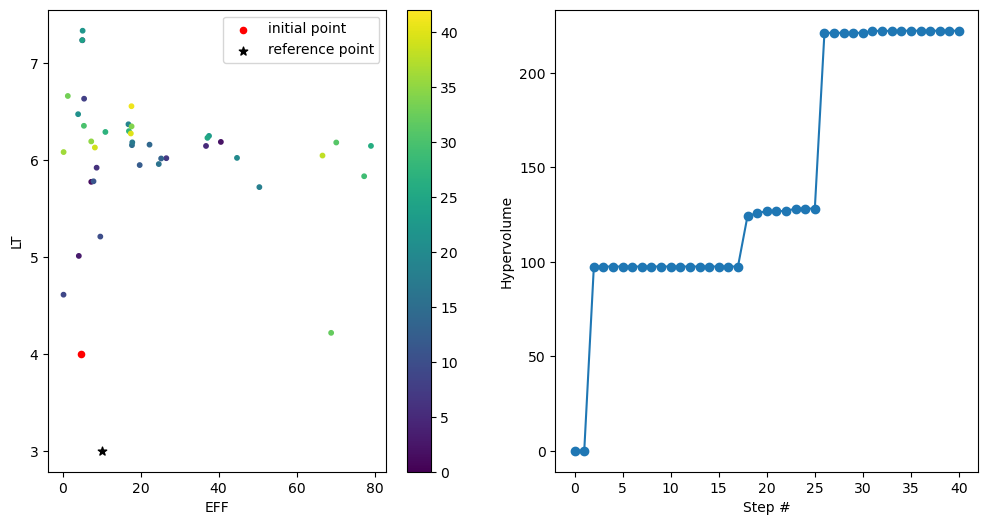

In [23]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(opt.data, i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

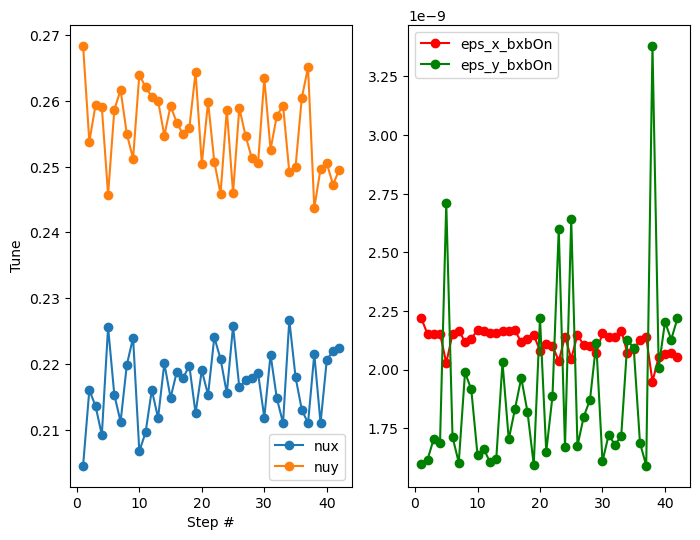

In [24]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [25]:
# This will save optimizer state
from datetime import datetime
opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_exp_moga_dump.json')

'{\n  "optimizer": {\n    "tag": "96506521a1",\n    "store_history": true,\n    "dump_every_step": true,\n    "history_directory": null,\n    "execution_mode": "sync"\n  },\n  "generator": {\n    "name": "aps_moga",\n    "population_size": 8,\n    "crossover_probability": 0.9,\n    "mutation_probability": 1.0,\n    "population_file": null,\n    "output_path": null,\n    "population": {\n      "SVD0": {\n        "23": -0.3296934251,\n        "27": -0.3296934251,\n        "9": -0.4590165617,\n        "32": -0.4538699978,\n        "3": -0.2047984068,\n        "24": -0.2820027482,\n        "20": -0.4048909971,\n        "35": -0.4048909971\n      },\n      "SH1": {\n        "23": -0.0235343411,\n        "27": -0.0242707339,\n        "9": 0.2847943546,\n        "32": 0.320057437,\n        "3": 0.320057437,\n        "24": 0.320057437,\n        "20": -0.3956946485,\n        "35": -0.3896473265\n      },\n      "SH3": {\n        "23": 0.007368667,\n        "27": -0.0817931109,\n        "9": 0.0